A vs swap slippage

In [1]:
import sys, os
sys.path.append("../../")

from utils.contract_utils import init_contract
from utils.network_utils import configure_network

import brownie
from brownie.network import chain

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)
brownie.network.connect('mainnet-fork')


Launching 'ganache-cli --port 8545 --gasLimit 12000000 --accounts 10 --hardfork istanbul --mnemonic brownie --fork https://eth-mainnet.alchemyapi.io/v2/AxU0de70ONfvbD-3_pQX0wUlaBK6g3G4 --chainId 1'...


In [4]:
pool_contract_addr = "0x9D0464996170c6B9e75eED71c68B99dDEDf279e8"  # cvxcrv pool addr

pool_contract = init_contract(contract_addr=pool_contract_addr)
pool_info = pool_contract.info()

initial_A = pool_contract.initial_A()
initial_A_time = pool_contract.initial_A_time()
A = pool_contract.A()
A_precise = pool_contract.A_precise()
A_precision = int(A_precise/A)

print(f"pool param details:")
print(f"initial_A: {initial_A}")
print(f"initial_A_time: {initial_A_time}")
print(f"A: {A}")
print(f"A_precise: {A_precise}")
print(f"A_precision: {A_precision}")

  @title StableSwap
  @notice 2 coin pool implementation with no lending
  @author Curve.Fi
  @details Optimized to only support ERC20's with 18
           decimals that return True/revert

pool param details:
initial_A: 5000
initial_A_time: 0
A: 50
A_precise: 5000
A_precision: 100


# Swap rates as a function of A

In [5]:
sender = brownie.accounts.at(init_contract("0xb9fc157394af804a3578134a6585c0dc9cc990d4").admin(), force=True)

In [6]:
dx = 10000 * 1e18

In [7]:
future_A = int(500)
A_ramp_steps = int(10)
A_params_simulation = list(range(A, future_A+A_ramp_steps, A_ramp_steps))

coin A to B

make snapshot of chain first:

In [8]:
chain.snapshot()
t0 = chain.time()
t1 = int(t0 + 7 * 86400)

In [9]:
swap_rates_A_to_B = []
for amplification_factor in A_params_simulation:

    pool_contract.ramp_A(amplification_factor, t1, {"from": sender})

    chain.sleep(t1)
    chain.mine()

    dy = pool_contract.get_dy(0, 1, dx)

    swap_rates_A_to_B.append(dy)

    chain.revert()

swap_rates_A_to_B

Transaction sent: 0x985db7288626bd02558de9baa7f0d22ad8e6fd82104f902ef2ed6613b0096bcd
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 896
  Vyper_contract.ramp_A confirmed   Block: 13257693   Gas used: 72974 (0.61%)

Transaction sent: 0xcdae9a59886c29404d628832286b4432495d7d56387e4a796eaffd4bbeaf9876
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 896
  Vyper_contract.ramp_A confirmed   Block: 13257693   Gas used: 77174 (0.64%)

Transaction sent: 0x0d872654ed11fb7c19f804b48fd43f32e1c6a7b7aeea4ae855063d45a74b2f5e
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 896
  Vyper_contract.ramp_A confirmed   Block: 13257693   Gas used: 77174 (0.64%)

Transaction sent: 0x5f0e57b9692f27caf389439a433b10a0ef5b37c4cb657ae48bd34a042b8258b7
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 896
  Vyper_contract.ramp_A confirmed   Block: 13257693   Gas used: 77174 (0.64%)

Transaction sent: 0xea2ca84e148e775a7f625a520a2c7e4c38512b3448db23863da94c45d8d92cc1
  Gas price: 0.0 gwei   Gas lim

[10041279271221107565261,
 10032041673604161208176,
 10025409014476153260049,
 10020415588172915324129,
 10016520534304235270585,
 10013397357339982621149,
 10010837298890585213848,
 10008700655138865484522,
 10006890404731232485385,
 10005337064951809078786,
 10003989568362766369236,
 10002809541068794958075,
 10001767589504133830642,
 10000840818637248903039,
 10000011130107813474222,
 9999264028574707600979,
 9998587767613348107430,
 9997972727575749199473,
 9997410955098438584640,
 9996895817291767626411,
 9996421738618082384431,
 9995983998275219550595,
 9995578572452272638612,
 9995202010276468135210,
 9994851335344651391549,
 9994523966887976461913,
 9994217656149675481360,
 9993930434657631822979,
 9993660571875664956883,
 9993406540307851507223,
 9993166986569202025853,
 9992940707265540315151,
 9992726628775003889698,
 9992523790214190252512,
 9992331329018697733193,
 9992148468681596905284,
 9991974508282234365171,
 9991808813507635576409,
 9991650808924046884078,
 999149997

coin B to A

In [10]:
swap_rates_B_to_A = []
for amplification_factor in A_params_simulation:

    pool_contract.ramp_A(amplification_factor, t1, {"from": sender})

    chain.sleep(t1)
    chain.mine()

    swap_rates_B_to_A.append(pool_contract.get_dy(1, 0, dx))

    chain.revert()

swap_rates_B_to_A

Transaction sent: 0x985db7288626bd02558de9baa7f0d22ad8e6fd82104f902ef2ed6613b0096bcd
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 896
  Vyper_contract.ramp_A confirmed   Block: 13257693   Gas used: 72974 (0.61%)

Transaction sent: 0xcdae9a59886c29404d628832286b4432495d7d56387e4a796eaffd4bbeaf9876
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 896
  Vyper_contract.ramp_A confirmed   Block: 13257693   Gas used: 77174 (0.64%)

Transaction sent: 0x0d872654ed11fb7c19f804b48fd43f32e1c6a7b7aeea4ae855063d45a74b2f5e
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 896
  Vyper_contract.ramp_A confirmed   Block: 13257693   Gas used: 77174 (0.64%)

Transaction sent: 0x5f0e57b9692f27caf389439a433b10a0ef5b37c4cb657ae48bd34a042b8258b7
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 896
  Vyper_contract.ramp_A confirmed   Block: 13257693   Gas used: 77174 (0.64%)

Transaction sent: 0xea2ca84e148e775a7f625a520a2c7e4c38512b3448db23863da94c45d8d92cc1
  Gas price: 0.0 gwei   Gas lim

[9928770042508444129242,
 9937956058519849035486,
 9944562172818460383494,
 9949541412945155939567,
 9953428864314845449113,
 9956548140639472891262,
 9959106460329834370387,
 9961242659723528361251,
 9963053250963648405151,
 9964607408040495399219,
 9965956006457539741500,
 9967137298507853734171,
 9968180599692590950085,
 9969108754553439953835,
 9969939828758120559090,
 9970688296618903946616,
 9971365891267827974424,
 9971982224236867851174,
 9972545244256157047440,
 9973061581929276216439,
 9973536812085798075621,
 9973975655872017948156,
 9974382138133449673529,
 9974759711217947401532,
 9975111353271066312557,
 9975439646951510228437,
 9975746842970707573319,
 9976034911763703413071,
 9976305585799748328621,
 9976560394452855353376,
 9976800692915192689588,
 9977027686307760163356,
 9977242449894002530431,
 9977445946111955536290,
 9977639038994186816319,
 9977822506431285486672,
 9977997050645988995591,
 9978163307175315519371,
 9978321852602901475473,
 9978473211239828501992,


add decimals

In [11]:
swap_rates_A_to_B = [round(i*1e-18, 4) for i in swap_rates_A_to_B]
swap_rates_B_to_A = [round(i*1e-18, 4) for i in swap_rates_B_to_A]

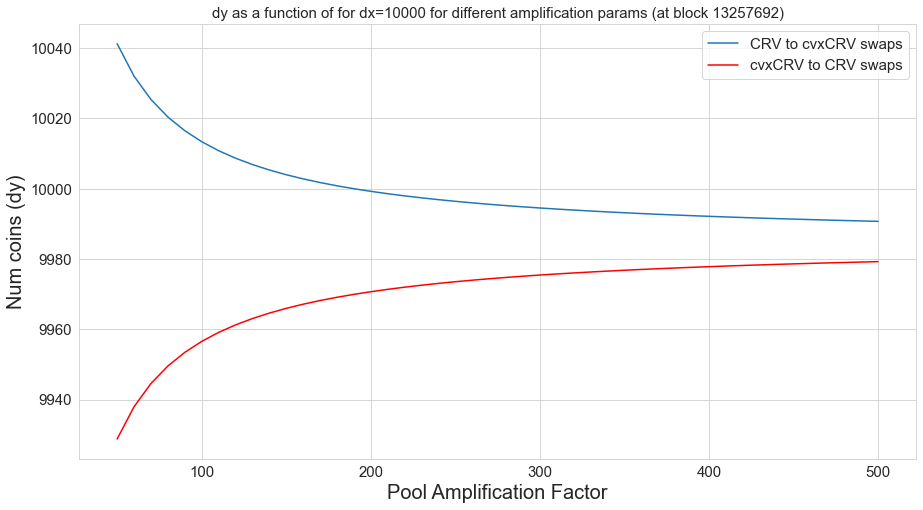

In [12]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))

ax.plot(A_params_simulation, swap_rates_A_to_B, label="CRV to cvxCRV swaps")
ax.plot(A_params_simulation, swap_rates_B_to_A, 'r', label="cvxCRV to CRV swaps")

ax.set_xlabel("Pool Amplification Factor", fontsize=20)
ax.set_ylabel("Num coins (dy)", fontsize=20)
ax.set_title(f"dy as a function of for dx={int(dx*1e-18)} for different amplification params (at block {brownie.web3.eth.block_number})", fontsize=15);
ax.tick_params(axis='both', which='major', labelsize=15);

ax.legend(fontsize=15)

disconnect.

In [13]:
brownie.network.disconnect()

Terminating local RPC client...
